In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys, shutil
sys.path.append('../../../fastai')

# this file contains all the main external libs used
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
# DS_PATH = '../../../../_datasets/kaggle_dog-breed-identification'
DS_PATH = '../../../datasets/dog-breed-identification'

PATH = 'data/dog-breed-identification'

In [4]:
arch = resnet34
sz = 224
bsz = 64

## 1. Data preparation

In [5]:
os.makedirs(f'{PATH}/models', exist_ok=True)
os.makedirs(f'{PATH}/tmp', exist_ok=True)

abs_ds_path = os.path.abspath(DS_PATH)

# symlink to root datasets so can use same data in other projects
!ln -s {abs_ds_path}/train {PATH}
!ln -s {abs_ds_path}/test {PATH}

ln: failed to create symbolic link 'data/dog-breed-identification/train': File exists
ln: failed to create symbolic link 'data/dog-breed-identification/test': File exists


In [6]:
labels_csv = f'{DS_PATH}/labels.csv'

labels_df = pd.read_csv(labels_csv)
n = len(labels_df)

print(n)
labels_df.head()

10222


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [7]:
# get cross validation indexes using fastai framework (default = %20 of train)
val_idxs = get_cv_idxs(n)

print(n, len(val_idxs))

10222 2044


## 2. Review Data

In [8]:
# 1. What is the class distribution? (what are 10 most common classes)
print(f'Unique classes: {len(labels_df.breed.unique())}')

labels_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)[:10]

Unique classes: 120


id
breed                    
scottish_deerhound    126
maltese_dog           117
afghan_hound          116
entlebucher           115
bernese_mountain_dog  114
shih-tzu              112
great_pyrenees        111
pomeranian            111
basenji               110
samoyed               109

In [9]:
# 2. What is the image size distribution? (what is the avg. height(rows) and width(cols))
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

data = ImageClassifierData.from_csv(PATH, csv_fname=f'{DS_PATH}/labels.csv', 
                                    folder='train', test_name='test', 
                                    bs=bsz, tfms=tfms, val_idxs=val_idxs, suffix='.jpg')

(500, 375)


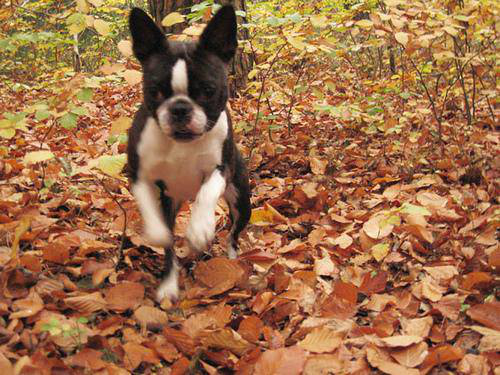

In [10]:
fname = f'{DS_PATH}/{data.trn_ds.fnames[0]}'; fname
img = Image.open(fname)

print(img.size)
img

In [11]:
trn_sizes = { fname: Image.open(f'{DS_PATH}/{fname}').size for fname in data.trn_ds.fnames }
trn_sizes[data.trn_ds.fnames[0]]

(500, 375)

In [12]:
row_sz, col_sz = list(zip(*trn_sizes.values()))

row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

print(f'Average image size (H x W): {int(row_sz.mean())} x {int(col_sz.mean())}')

Average image size (H x W): 443 x 387


(array([  148.,   600.,  1307.,  1205.,  4581.,   122.,    78.,    62.,    15.,     7.]),
 array([  97. ,  186.3,  275.6,  364.9,  454.2,  543.5,  632.8,  722.1,  811.4,  900.7,  990. ]),
 <a list of 10 Patch objects>)

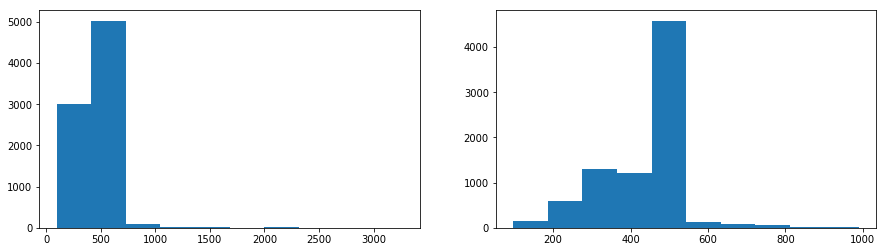

In [13]:
# height distribution
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4) )
ax1.hist(row_sz)
ax2.hist(row_sz[row_sz < 1000])

(array([  243.,   721.,  2218.,  2940.,  1837.,    95.,    29.,    29.,     8.,     8.]),
 array([ 102. ,  190.2,  278.4,  366.6,  454.8,  543. ,  631.2,  719.4,  807.6,  895.8,  984. ]),
 <a list of 10 Patch objects>)

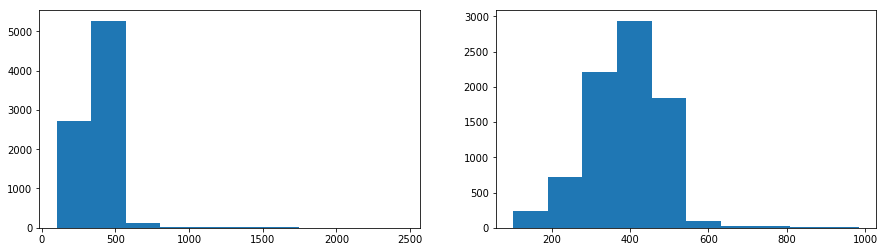

In [14]:
# width distribution
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4) )
ax1.hist(col_sz)
ax2.hist(col_sz[col_sz < 1000])

## 3. Training

**Review: easy steps to train a world-class image classifier:**
1. Enable data augmentation, and precompute=True
1. Use lr_find() to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use lr_find() again
1. Train full network with cycle_mult=2 until over-fitting

In [15]:
def get_data(sz, bsz, val_idxs=[0], test_name='test'):
    # 20171112 - due to current bug in framework, you can't set val_idxs=None so we
    #            set it to [0] which will use all but 1 example for training
    
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

    data = ImageClassifierData.from_csv(PATH, csv_fname=f'{DS_PATH}/labels.csv', 
                                        folder='train', test_name=test_name, 
                                        bs=bsz, tfms=tfms, val_idxs=val_idxs, suffix='.jpg')

    # Why is minimum size 300?
    # see http://forums.fast.ai/t/dog-breed-identification-challenge/7464/53?u=wgpubs
    # "Since we have max_zoom=1.1, I figured we should ensure our images are at release sz*1.1
    # and I figured resizing them to 340x340 would save plenty of time, and leave plenty of room to experiment.
    return data if sz > 300 else data.resize(340, 'tmp')

In [16]:
# 1. Enable data augmentation, and precompute=True
data = get_data(sz, bsz, val_idxs)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

A Jupyter Widget

                                                      
100%|██████████| 162/162 [00:46<00:00,  3.47it/s]


A Jupyter Widget

 84%|████████▍ | 108/128 [00:01<00:00, 97.68it/s, loss=16.4] 


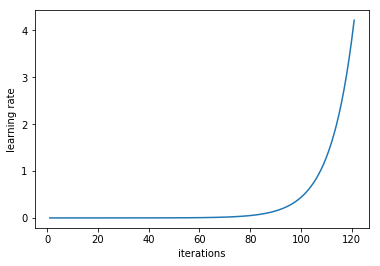

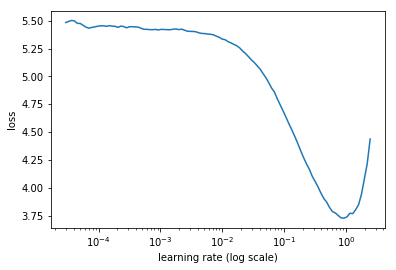

In [17]:
# 2. Use lr_find() to find highest learning rate where loss is still clearly improving
learn.lr_find()

learn.sched.plot_lr(); plt.show()
learn.sched.plot(); plt.show()

In [20]:
# 3. Train last layer from precomputed activations for 1-2 epochs
lr = 1e-2

learn.fit(lr, 2)

A Jupyter Widget

[ 0.       0.44791  0.4886   0.84303]                         
[ 1.       0.47548  0.47769  0.84346]                         



In [21]:
# 4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
learn.precompute = False

learn.fit(lr, 2, cycle_len=1)

A Jupyter Widget

[ 0.       0.57665  0.47748  0.84984]                        
[ 1.       0.60891  0.47032  0.8474 ]                        



In [22]:
# underfitting, means cycle_len = 1 is too short ... e.g., is popping out before it finds something better
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.56249  0.46865  0.85133]                        
[ 1.       0.59788  0.46333  0.84981]                        
[ 2.       0.57699  0.46042  0.8513 ]                        
[ 3.       0.56925  0.4608   0.85127]                        
[ 4.       0.58771  0.45805  0.85469]                        
[ 5.       0.57079  0.45586  0.85664]                        
[ 6.       0.55636  0.45904  0.85176]                        



In [23]:
log_preds, y = learn.TTA()
accuracy(log_preds, y)

0.86692759295499022

In [24]:
learn.save('rn34_224_step4')

In [25]:
learn.load('rn34_224_step4')

In [26]:
# WILL NOT DO IN THIS PROBLEM - Because the training dataset is so similar to original training dataset,
# trainign the convolutional layers will not improve network (in fact, this set is a subset of
# ImageNet, the same dataset that our pre-trained model was trained on)

# 5. Unfreeze all layers
# learn.unfreeze()

# 6. Set earlier layers to 3x-10x lower learning rate than next higher layer
# lr = np.array([1e-7, 1e-6, 1e-5])

# 7. Use lr_find() again
# learn.lr_find(lr/1000)
# learn.sched.plot()

# update differential lrs if lr_find() informs us too.

# 8. Train full network with cycle_mult=2 until over-fitting
# learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
# learn.save('rn34_224_step8')

### 3.1 Continue training on larger images

In [27]:
# try increasing the size; moving to larger images can help reduce overfitting
learn.set_data(get_data(299, bsz, val_idxs))

learn.freeze() # just to make sure that every layer EXCEPT the last is frozen

A Jupyter Widget


100%|██████████| 162/162 [01:41<00:00,  1.59it/s]


In [28]:
learn.fit(lr, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.54522  0.4117   0.8694 ]                        
[ 1.       0.56248  0.40929  0.87672]                        
[ 2.       0.58451  0.41004  0.8777 ]                        



In [29]:
# underfitting so add cycle_mult to give learner a chance to find best parameters before jumping out
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.54045  0.40914  0.87187]                        
[ 1.       0.56271  0.40239  0.8777 ]                        
[ 2.       0.55466  0.40529  0.87669]                        
[ 3.       0.55017  0.40014  0.87819]                        
[ 4.       0.53926  0.40214  0.87868]                        
[ 5.       0.53097  0.39835  0.8762 ]                        
[ 6.       0.52505  0.3983   0.87868]                        



In [30]:
# last scores: [ 6.       0.53188  0.39652  0.87951]   
log_preds, y = learn.TTA()
accuracy(log_preds, y)

0.88307240704500978

In [31]:
learn.save('rn34_229_step4')

In [32]:
learn.load('rn34_229_step4')

### 3.2 Try using K-Fold CV - TODO!

In [ ]:
# reset hyperparams
lr = 1e-2; sz=224; bsz=10;

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)

# get folds
kfolds = [ (train_idxs, val_idxs) for train_idxs, val_idxs in skf.split(labels_df.id, labels_df.breed) ]
print(len(kfolds))

In [ ]:
data = get_data(sz, bsz, kfolds[0][1], test_name=None)
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)

## Submit predictions

In [33]:
log_preds, y = learn.TTA(is_test=True)

In [45]:
probs = np.exp(log_preds)

In [48]:
probs.shape, len(data.test_ds.fnames)

((10357, 120), 10357)

In [70]:
df_subm = pd.DataFrame(data=probs, columns=data.classes)
# df_subm.head()

In [71]:
df_subm.insert(0, 'id', data.test_ds.fnames)
# df_subm.head()

In [72]:
df_subm.id = df_subm.id.apply(lambda x: str(x).replace('test/','').replace('.jpg', ''))

In [73]:
df_subm.sort_values('id', ascending=True, inplace=True)
df_subm.head()

id  affenpinscher  afghan_hound  \
9877  000621fb3cbb32d8935728e48679680e   8.798668e-08  2.211735e-08   
628   00102ee9d8eb90812350685311fe5890   1.802554e-08  1.019174e-09   
3474  0012a730dfa437f5f3613fb75efcd4ce   6.293662e-10  1.052707e-05   
8255  001510bc8570bbeee98c8d80c8a95ec1   5.876182e-04  6.953927e-07   
437   001a5f3114548acdefa3d4da05474c2e   6.353229e-02  4.716022e-05   

      african_hunting_dog      airedale  american_staffordshire_terrier  \
9877         3.245682e-09  2.835276e-11                    6.367412e-10   
628          1.819129e-08  3.237619e-09                    2.079738e-07   
3474         1.200476e-07  1.081692e-09                    1.097678e-10   
8255         6.519043e-07  1.581761e-06                    8.425772e-04   
437          1.666622e-07  6.725976e-08                    1.474534e-07   

       appenzeller  australian_terrier       basenji        basset  \
9877  1.913760e-09        3.303036e-10  3.412608e-10  4.293419e-10   
628   3.130769e-07        7.024376e-08  6.538138e-09  1.056470e-08   
3474  1.011718e-08        3.430489e-10  7.939255e-11  7.690288e-07   
8255  1.116488e-06        5.333670e-08  1.375807e-06  5.659218e-06   
437   2.262320e-08        2.979512e-06  3.012555e-08  5.710690e-08   

            ...            toy_poodle   toy_terrier        vizsla  \
9877        ...          3.119199e-09  5.803960e-09  9.979318e-10   
628         ...          4.848097e-08  4.891595e-08  8.305102e-09   
3474        ...          8.517987e-10  6.376020e-09  3.851987e-07   
8255        ...          3.982278e-06  7.990905e-08  1.252544e-04   
437         ...          7.550248e-06  4.059394e-07  4.441583e-07   

      walker_hound    weimaraner  welsh_springer_spaniel  \
9877  7.150432e-11  1.206526e-09            2.178433e-09   
628   9.122362e-09  2.863159e-08            3.081319e-09   
3474  5.818608e-07  2.486233e-07            1.802374e-04   
8255  2.608066e-05  1.018532e-04            4.421658e-08   
437   5.215883e-08  8.038720e-07            3.330247e-08   

      west_highland_white_terrier       whippet  wire-haired_fox_terrier  \
9877                 1.094461e-10  1.416952e-09             1.905434e-09   
628                  9.902662e-06  3.890519e-09             4.706640e-09   
3474                 1.141892e-08  1.310048e-07             1.047367e-08   
8255                 7.721098e-08  2.589029e-05             5.432339e-07   
437                  6.783977e-07  8.906206e-08             1.780382e-06   

      yorkshire_terrier  
9877       1.972113e-08  
628        4.161882e-09  
3474       2.157790e-08  
8255       1.591554e-06  
437        3.259481e-04  

[5 rows x 121 columns]

In [74]:
df_subm.to_csv(f'{PATH}/20171112_submittion.csv', index=None)

## Analyzing Results

In [7]:
df_subm = pd.read_csv(f'{PATH}/20171112_submittion.csv', index_col=None)

In [8]:
df_subm.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e   8.798668e-08  2.211735e-08   
1  00102ee9d8eb90812350685311fe5890   1.802554e-08  1.019174e-09   
2  0012a730dfa437f5f3613fb75efcd4ce   6.293662e-10  1.052707e-05   
3  001510bc8570bbeee98c8d80c8a95ec1   5.876182e-04  6.953927e-07   
4  001a5f3114548acdefa3d4da05474c2e   6.353229e-02  4.716022e-05   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         3.245682e-09  2.835276e-11                    6.367412e-10   
1         1.819129e-08  3.237619e-09                    2.079738e-07   
2         1.200476e-07  1.081692e-09                    1.097678e-10   
3         6.519043e-07  1.581761e-06                    8.425772e-04   
4         1.666622e-07  6.725976e-08                    1.474534e-07   

    appenzeller  australian_terrier       basenji        basset  \
0  1.913760e-09        3.303036e-10  3.412608e-10  4.293419e-10   
1  3.130769e-07        7.024376e-08  6.538138e-09  1.056470e-08   
2  1.011718e-08        3.430489e-10  7.939255e-11  7.690288e-07   
3  1.116488e-06        5.333670e-08  1.375807e-06  5.659218e-06   
4  2.262320e-08        2.979512e-06  3.012555e-08  5.710690e-08   

         ...            toy_poodle   toy_terrier        vizsla  walker_hound  \
0        ...          3.119199e-09  5.803960e-09  9.979318e-10  7.150432e-11   
1        ...          4.848097e-08  4.891595e-08  8.305102e-09  9.122362e-09   
2        ...          8.517987e-10  6.376020e-09  3.851987e-07  5.818608e-07   
3        ...          3.982278e-06  7.990905e-08  1.252544e-04  2.608066e-05   
4        ...          7.550248e-06  4.059394e-07  4.441583e-07  5.215883e-08   

     weimaraner  welsh_springer_spaniel  west_highland_white_terrier  \
0  1.206526e-09            2.178433e-09                 1.094461e-10   
1  2.863159e-08            3.081319e-09                 9.902662e-06   
2  2.486233e-07            1.802374e-04                 1.141892e-08   
3  1.018532e-04            4.421658e-08                 7.721098e-08   
4  8.038720e-07            3.330247e-08                 6.783977e-07   

        whippet  wire-haired_fox_terrier  yorkshire_terrier  
0  1.416952e-09             1.905434e-09       1.972113e-08  
1  3.890519e-09             4.706640e-09       4.161882e-09  
2  1.310048e-07             1.047367e-08       2.157790e-08  
3  2.589029e-05             5.432339e-07       1.591554e-06  
4  8.906206e-08             1.780382e-06       3.259481e-04  

[5 rows x 121 columns]

In [9]:
df_subm[df_subm.columns[1:]] = df_subm[df_subm.columns[1:]].apply(lambda x:  np.clip(x, (1-0.999998)/1, 0.999998))
df_subm.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.000002      0.000002   
1  00102ee9d8eb90812350685311fe5890       0.000002      0.000002   
2  0012a730dfa437f5f3613fb75efcd4ce       0.000002      0.000011   
3  001510bc8570bbeee98c8d80c8a95ec1       0.000588      0.000002   
4  001a5f3114548acdefa3d4da05474c2e       0.063532      0.000047   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.000002  0.000002                        0.000002     0.000002   
1             0.000002  0.000002                        0.000002     0.000002   
2             0.000002  0.000002                        0.000002     0.000002   
3             0.000002  0.000002                        0.000843     0.000002   
4             0.000002  0.000002                        0.000002     0.000002   

   australian_terrier   basenji    basset        ...          toy_poodle  \
0            0.000002  0.000002  0.000002        ...            0.000002   
1            0.000002  0.000002  0.000002        ...            0.000002   
2            0.000002  0.000002  0.000002        ...            0.000002   
3            0.000002  0.000002  0.000006        ...            0.000004   
4            0.000003  0.000002  0.000002        ...            0.000008   

   toy_terrier    vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0     0.000002  0.000002      0.000002    0.000002                0.000002   
1     0.000002  0.000002      0.000002    0.000002                0.000002   
2     0.000002  0.000002      0.000002    0.000002                0.000180   
3     0.000002  0.000125      0.000026    0.000102                0.000002   
4     0.000002  0.000002      0.000002    0.000002                0.000002   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.000002  0.000002                 0.000002   
1                     0.000010  0.000002                 0.000002   
2                     0.000002  0.000002                 0.000002   
3                     0.000002  0.000026                 0.000002   
4                     0.000002  0.000002                 0.000002   

   yorkshire_terrier  
0           0.000002  
1           0.000002  
2           0.000002  
3           0.000002  
4           0.000326  

[5 rows x 121 columns]

In [10]:
df_subm.to_csv(f'{PATH}/20171112_submittion_2.csv', index=None)